## INITIAL PACKAGES

In [1]:
from PIL import Image
import os, glob
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib

import tensorflow as tf
from tensorflow import keras

## LOAD DATA

In [19]:
# 한글명 -> index
item_list = {
    '단화': 0,
    '데님': 1,
    '미니 원피스': 2, 
    '미니스커트': 3,
    '미디 원피스': 4,
    '반팔': 5,
    '셔츠': 6,
    '슬랙스': 7,
    '카디건': 8, 
    '카라 티셔츠': 9,
    '후드 집업': 10
}
# 파일 경로 지정
current_dir = os.path.join(os.getcwd(), 'drive/My Drive/Colab Notebooks')
item_path = os.path.join(current_dir, 'musinsa_data')
item_csv = {}

In [20]:
# csv파일 읽음
for i in item_list:
  item = os.path.join(item_path, i + '.csv')
  item_csv[i] = pd.read_csv(item, encoding='CP949').fillna('0')
  # korean to index
  item_csv[i]['category'] = item_list[i]

In [21]:
item_csv['단화']

,index,filename,title,category,tag,brand,pageView,sales,likes,price,satisfation,reviewContents,hashkeywords,keywords,contents
0,0,0.jpg,올드스쿨 - 블랙 / VN000D3HY281 VN-0D3HY28 / OLD SKOO...,0,운동화 보드화 블랙 OLD SKOOL 스니커즈 올드스쿨 캔버스 클래식 캐리오버,VANS,5.9만 회 이상,6.1만 개 이상,0,69000,95.76% 만족,사이즈 커요 : 9% 보통이에요 : 90% 작아요 : 1% 밝기 밝아요 : 6% 보...,#사이즈 #신발 #반스 #올드스쿨 #처음 #어디 #역시 #때 #발볼 #신어 #업 #...,"('사이즈', 76) ('신발', 56) ('반스', 41) ('올드스쿨', 40)...",올드스쿨은 반스의 클래식한 스케이트 슈즈이며 반스의 아이콘으로 자리 잡은 사이드 ...
1,1,1.jpg,BW 독일군 스니커즈 - 화이트 / BZ0579 BW ARMY - WHITE,0,독일군 스니커즈 화이트 운동화 클래식,ADIDAS,7.5만 회 이상,3.7만 개 이상,0,139000,95.24% 만족,사이즈 커요 : 23% 보통이에요 : 75% 작아요 : 2% 밝기 밝아요 : 23%...,#사이즈 #신발 #독일군 #조금 #추천 #구매 #아디다스 #발볼 #수 #또 #디자인...,"('사이즈', 96) ('신발', 53) ('독일군', 49) ('조금', 44) ...",※ 스니커즈의 아웃솔은 220사이즈 제외 5단위로만 제작되어 구매사이즈와 다를 수...
2,2,2.jpg,스케이트 하이 - 블랙 / VN000D5IB8C1 반스 스케이트 하이 블랙 / VN...,0,하이탑 스니커즈 스케이트보드 클래식 스케이트하이 캔버스 캐리오버 블랙,VANS,2.6천 회 이상,3만 개 이상,0,79000,97.54% 만족,사이즈 커요 : 6% 보통이에요 : 92% 작아요 : 2% 밝기 밝아요 : 10% ...,#신발 #반스 #신어 #사이즈 #무난 #포인트 #업 #색 #거 #하나 #생각 #것 ...,"('신발', 82) ('반스', 79) ('신어', 49) ('사이즈', 48) (...",올드스쿨 다음으로 사이드 스트라이프를 가미한 실루엣인 스케이트-하이는 1978년에 ...
3,3,3.jpg,클래식 슬립온 - (체커보드) 블랙:화이트 / VN000EYEBWW1 Classic...,0,스니커즈 캐리오버 화이트 슬립온 체커보드 캔버스 스케이트보드 블랙,VANS,3만 회 이상,2.8만 개 이상,0,59000,97.28% 만족,사이즈 커요 : 5% 보통이에요 : 90% 작아요 : 5% 밝기 밝아요 : 10% ...,#사이즈 #것 #반스 #업 #정사 #이즈 #신발 #구매 #옷 #약간 #발등 #무난 ...,"('사이즈', 72) ('것', 67) ('반스', 63) ('업', 54) ('정...",1979년에 탄생한 반스의 클래식 슬립온은 탄생 직후 반스의 대표적인 실루엣이 되었...
4,4,4.jpg,스케이트 하이 - 네이비 / VN000D5INVY1 반스 스케이트 하이 / VN00...,0,캔버스 스케이트보드 클래식 하이탑 스케이트하이 스니커즈 캐리오버,VANS,1.1천 회 이상,2.5만 개 이상,0,79000,97.54% 만족,사이즈 커요 : 6% 보통이에요 : 92% 작아요 : 2% 밝기 밝아요 : 10% ...,#신발 #반스 #신어 #사이즈 #무난 #포인트 #업 #색 #거 #하나 #생각 #것 ...,"('신발', 82) ('반스', 79) ('신어', 49) ('사이즈', 48) (...",올드스쿨 다음으로 사이드 스트라이프를 가미한 실루엣인 스케이트-하이는 1978년에 ...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3243,3243,3243.jpg,올림 Olym,0,마크모크 여자스니커즈 MAC MOC 여성스니커즈 olym,MAC MOC,31,0,0,95000,등록된 후기가 없습니다.,사이즈 커요 : 0% 보통이에요 : 0% 작아요 : 0% 밝기 밝아요 : 0% 보통...,0,0,0
3244,3244,3244.jpg,삭스레이스 하이탑 no.196 no.196,0,하이탑 노모니코 nomonico 발렌시아 삭스,NOMONICO,80,0,0,168000,90% 만족,사이즈 커요 : 0% 보통이에요 : 0% 작아요 : 0% 밝기 밝아요 : 0% 보통...,#신발 #걱정 #디자인 #신고 #마음 #거 #약간 #빈티 #스타일 #때 #교환 #상...,"('신발', 6) ('걱정', 6) ('디자인', 6) ('신고', 6) ('마음'...",0
3245,3245,3245.jpg,빈티지 벨크로 스니커즈 no.707 NO.707,0,노모니코 nomonico,NOMONICO,45,0,0,158000,100% 만족,사이즈 커요 : 0% 보통이에요 : 100% 작아요 : 0% 밝기 밝아요 : 0% ...,#접 #브랜드 #라코스테 #이건 #쿠션 #감 #폭 #처음 #구매 #막상 #다자 #찍...,"('접', 6) ('브랜드', 6) ('라코스테', 6) ('이건', 6) ('쿠션...",0
3246,3246,3246.jpg,W IAN(SKIN-W014161),0,언노운 스니커즈 여성화 UNNOWN,UNNOWN,36,0,0,105000,등록된 후기가 없습니다.,사이즈 커요 : 0% 보통이에요 : 0% 작아요 : 0% 밝기 밝아요 : 0% 보통...,0,0,0


In [4]:
# 한글 데이터를 숫자로(추후 크롤링 코드 수정해서 숫자 값으로 받아오게)
# 100만 회 이상 -> 1000000
def numtext_to_num(p):
  mult = 1
  p = p.strip().replace(' ','')
  p = p.replace('회이상', '')
  if p.endswith('천'):
    p = p.replace('천', '')
    mult = 1000
  elif p.endswith('만'):
    p = p.replace('만', '')
    mult = 10000
  ret = int(float(p) * mult)
  return ret
t2n = np.vectorize(numtext_to_num)

In [5]:
# 이미지 크기
image_w = 60 
image_h = 60
# 모든 이미지를 X에 저장
# image, ndarray
X = np.empty((0,image_w, image_h, 3))
# label, list
Y = []

# 카테고리 별로 이미지 파일 읽음
for item in item_list:
  # load saved .npy file
  try:
    # 이미지 numpy 배열이 저장되어 있는지 확인
    tempX = np.load(os.path.join(item_path, item + '.npy'))
    print('read ' + item + '.npy...')
  # read all .jpg file
  except:
    tempX = []
    image_path = os.path.join(item_path, item, '*.jpg')
    files = glob.glob(image_path)
    # 모든 이미지 파일 읽음
    for i, f in enumerate(files):
      img = Image.open(f) 
      img = img.convert("RGB")
      img = img.resize((image_w, image_h))
      # numpy
      data = np.asarray(img)
      tempX.append(data)
      if i % 100 == 0:
        print(i)
    tempX = np.array(tempX)
    print('save ' + item + '.npy...')
    np.save(os.path.join(item_path, item + '.npy'), tempX)
  # concat
  X = np.concatenate((X, tempX), axis=0)
  # set label
  Y += list(item_csv[item]['pageView'])
# 한글 숫자로 변환
Y = t2n(Y)
num_X = len(X)

read 단화.npy...
read 데님.npy...
read 미니 원피스.npy...
read 미니스커트.npy...
read 미디 원피스.npy...
read 반팔.npy...
read 셔츠.npy...
read 슬랙스.npy...
read 카디건.npy...
read 카라 티셔츠.npy...
read 후드 집업.npy...


In [7]:
print(X.shape)
print(Y.shape)

(28402, 60, 60, 3)
(28402,)


## DATA PREPROCESSING

In [8]:
# shuffle
index = np.argsort(Y)[:-1]
np.random.shuffle(index)
#rand_index = np.random.permutation(num_X)
X = X[index] / 255.0
# 좀더 선형으로 만들기
Y = np.log(Y[index] + 1)
Y = (Y - Y.min()) / (Y.max() - Y.min())
#Y = np.arctan(Y - Y.mean())

## Modeling

In [9]:
from keras.models import Sequential, load_model
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense
from keras.callbacks import EarlyStopping

In [10]:
# VGG16
class CNN():
  model = None
  def __init__(self):
    self.model = Sequential()
    self.model.add(Conv2D(filters=64,
                    kernel_size=(3, 3),
                    strides=(1, 1),
                    padding='same',
                    activation='relu',
                    input_shape=(60, 60, 3)))
    self.model.add(Conv2D(filters=64,
                    kernel_size=(3, 3),
                    strides=(1, 1),
                    activation='relu',
                    padding='same'))
    self.model.add(MaxPooling2D(pool_size=(2, 2),
                          strides=(2, 2)))
    
    self.model.add(Conv2D(filters=128,
                    kernel_size=(3, 3),
                    strides=(1, 1),
                    activation='relu',
                    padding='same'))
    self.model.add(Conv2D(filters=128,
                    kernel_size=(3, 3),
                    strides=(1, 1),
                    activation='relu',
                    padding='same'))
    self.model.add(MaxPooling2D(pool_size=(2, 2),
                          strides=(2, 2)))
    '''
    #self.model.add(Dropout(0.25))
    self.model.add(Conv2D(filters=256,
                    kernel_size=(3, 3),
                    strides=(1, 1),
                    activation='relu',
                    padding='same'))
    self.model.add(Conv2D(filters=256,
                    kernel_size=(3, 3),
                    strides=(1, 1),
                    activation='relu',
                    padding='same'))
    self.model.add(Conv2D(filters=256,
                    kernel_size=(3, 3),
                    strides=(1, 1),
                    activation='relu',
                    padding='same'))
    self.model.add(MaxPooling2D(pool_size=(2, 2),
                          strides=(2, 2)))
    #self.model.add(Dropout(0.5))
    self.model.add(Conv2D(filters=512,
                    kernel_size=(3, 3),
                    strides=(1, 1),
                    activation='relu',
                    padding='same'))
    self.model.add(Conv2D(filters=512,
                    kernel_size=(3, 3),
                    strides=(1, 1),
                    activation='relu',
                    padding='same'))
    self.model.add(Conv2D(filters=512,
                    kernel_size=(3, 3),
                    strides=(1, 1),
                    activation='relu',
                    padding='same'))
    self.model.add(MaxPooling2D(pool_size=(2, 2),
                          strides=(2, 2)))
    self.model.add(Conv2D(filters=512,
                    kernel_size=(3, 3),
                    strides=(1, 1),
                    activation='relu',
                    padding='same'))
    self.model.add(Conv2D(filters=512,
                    kernel_size=(3, 3),
                    strides=(1, 1),
                    activation='relu',
                    padding='same'))
    self.model.add(Conv2D(filters=512,
                    kernel_size=(3, 3),
                    strides=(1, 1),
                    activation='relu',
                    padding='same'))
    self.model.add(MaxPooling2D(pool_size=(2, 2),
                          strides=(2, 2)))
                          '''
    self.model.add(Flatten())
    #self.model.add(Dense(units=4096, kernel_regularizer=keras.regularizers.l2(0.001), activation='tanh'))
    self.model.add(Dense(units=4096, activation='relu'))
    #self.model.add(Dropout(0.25))
    self.model.add(Dense(units=4096, activation='relu'))
    #self.model.add(Dropout(0.25))
    self.model.add(Dense(units=1000, activation='relu'))
    self.model.add(Dense(units=1, activation='linear'))

    self.model.compile(loss='mae',
                  optimizer='adam',
                  metrics=['mae', 'mse'])

In [17]:
def train(train_images, train_labels, test_images, test_labels):
  # PARAMETERS
  epoch = 20
  batch_size = 512
  early = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1, mode='auto')

  # BUILD YOUR MODEL 
  model = CNN().model

  %%time
  hist = model.fit(train_images, train_labels, epochs=epoch, batch_size=batch_size,
            validation_data=(test_images[:-10000], test_labels[:-10000]), verbose=1, callbacks=[early])

  plt.plot(hist.history['loss'], 'b-', label="training")
  plt.plot(hist.history['val_loss'], 'r:', label="validation")
  plt.legend()
  plt.savefig(os.path.join(current_dir, 'loss.png'), dpi=300)
  plt.show()

  # Make prediction data frame
  test_pred = model.predict(test_images[-10000:])
  pred_labels = test_labels[-10000:]
  #index = np.argsort(pred_labels)
  index = np.arange(test_pred.shape[0])
  scatter = plt.scatter(index, pred_labels, c = 'b', s = 0.1, label='test label')
  scatter = plt.scatter(index, test_pred, c = 'r', s = 0.1, label='predict')
  plt.legend()
  plt.savefig(os.path.join(current_dir, 'predict.png'), dpi=300)
  plt.show()

  h5_file = os.path.join(current_dir, 'model.h5')
  model.save(h5_file)
  
  return model

CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 6.91 µs
Epoch 1/20
45/45 [==============================] - 31s 695ms/step - loss: 1.6015 - mae: 1.6015 - mse: 96.7099 - val_loss: 0.1063 - val_mae: 0.1063 - val_mse: 0.0213
Epoch 2/20
45/45 [==============================] - 29s 655ms/step - loss: 0.1030 - mae: 0.1030 - mse: 0.0180 - val_loss: 0.1027 - val_mae: 0.1027 - val_mse: 0.0168
Epoch 3/20
45/45 [==============================] - 29s 652ms/step - loss: 0.0987 - mae: 0.0987 - mse: 0.0165 - val_loss: 0.0984 - val_mae: 0.0984 - val_mse: 0.0162
Epoch 4/20
45/45 [==============================] - 29s 654ms/step - loss: 0.0973 - mae: 0.0973 - mse: 0.0163 - val_loss: 0.0976 - val_mae: 0.0976 - val_mse: 0.0164
Epoch 5/20
45/45 [==============================] - 29s 653ms/step - loss: 0.0956 - mae: 0.0956 - mse: 0.0160 - val_loss: 0.0967 - val_mae: 0.0967 - val_mse: 0.0170
Epoch 6/20
45/45 [==============================] - 29s 653ms/step - loss: 0.0946 - mae: 0.0946 - mse: 0.0157 

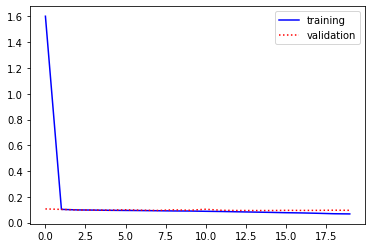

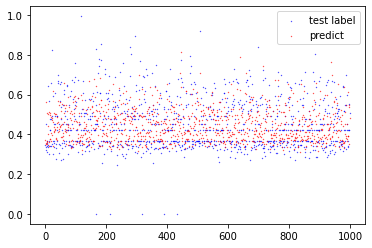

In [12]:
train_images = X[:int(num_X*0.8)]
train_labels = Y[:int(num_X*0.8)]
test_images = X[int(num_X*0.8):]
test_labels = Y[int(num_X*0.8):]

a = train(train_images, train_labels, test_images, test_labels)

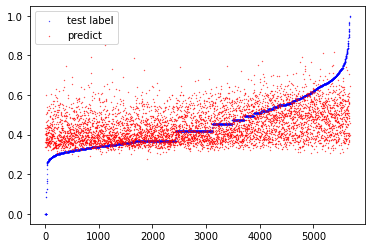

In [22]:
# Make prediction data frame
im = test_images[-10000:]
lab = test_labels[-10000:]
#im = train_images
#lab = train_labels
test_pred = a.predict(im)
pred_labels = lab
index = np.argsort(pred_labels)
#index = np.arange(test_pred.shape[0])
scatter = plt.scatter(np.arange(test_pred.shape[0]), pred_labels[index], c = 'b', s = 0.1, label='test label')
scatter = plt.scatter(np.arange(test_pred.shape[0]), test_pred[index], c = 'r', s = 0.1, label='predict')
plt.legend()
plt.savefig(os.path.join(current_dir, 'result.png'), dpi=300)
plt.show()

In [14]:
print(np.mean(pred_labels))
print(np.mean(test_pred))

0.45075276430450945
0.4434005
